In [156]:
import time
import astropy
import itertools

import numpy             as np
import pylab             as pl
import matplotlib.pyplot as plt
import astropy.units     as u

from   astropy.cosmology import FlatLambdaCDM
from   IPython.display   import YouTubeVideo
from   flops             import flops

In [2]:
%matplotlib notebook

plt.style.use('dark_background')

# DESI and the fastest supercomputer in the World

Understanding _how_ the 30 million galaxies surveyed by DESI actually formed in the Universe is hard, really hard.  So hard in fact that DESI exploits [Summit](https://www.olcf.ornl.gov/summit/), the world's fastest supercomputer at Oak Ridge National Lab to calculate how the distribution of galaxies should look depending on the type of Dark Energy:     

<img src="images/summit.jpg" alt="Drawing" style="width: 800px;"/>

Costing a cool 325 million dollars to build, Summit is capable of calculating addition and multiplication operations at $1.486 \times 10^{17}$ times a second, equivalent to $1.486 \times 10^{11}$ MegaFlops or MFLOPS.  For comparison, let's see what Binder provides (you'll need some patience): 

In [3]:
flops()



   FLOPS Python Program (Double Precision), V2.0 18 Dec 1992


   Module     Error        RunTime      MFLOPS

                            (usec)

     1      1.3856e-13      0.2184     64.0964

     2     -3.5279e+00      0.1122     62.3921

     3      9.6478e-14      0.2668     63.7277



0

So Summit is at least a billion times more powerful!  With this supercomputer, we can resolve the finest details of the distribution of _dark matter_ that all galaxies trace:

<img src="images/abacus.png" alt="Drawing" style="width: 600px;"/>

Here the brightest regions signify the densest regions of the Universe in which we expect to find more galaxies.  The video below shows that we have observed the exact same structures in real galaxies observed with experiments prior to DESI.  

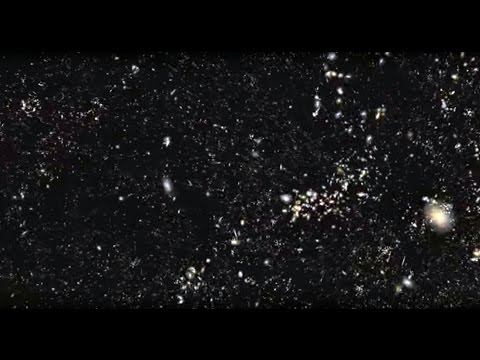

In [233]:
YouTubeVideo('08LBltePDZw', width=800, height=400)

Fortunately, the equations that describe the evolution of dark matter, rather than galaxies, are relatively simple for the Universe in which we seem to live.  All that is required is to track the gravitational attraction of dark matter particles on an expanding stage.

We approximate the evolution of dark matter by sampling the gravitational force, velocity and position with a set of fictitious particles that each represent a 'clump' of dark matter with some mass.  Of course, this means we cannot solve for the distribution of dark matter within a clump, but just the distribution amongst clumps that leads to the structure you can see above.  

To start,  we'll initialiase a set of clumps to random positions within a 3D cube and give them zero initial velocities.  Velocities will be generated at subsequent times as the ($1/r^2$) gravitational attraction of a particle to all others causes it to accelerate.

In [234]:
def init_dof(npt=1):
  xs     = np.random.uniform(0., 1., npt)
  ys     = np.random.uniform(0., 1., npt)
  zs     = np.random.uniform(0., 1., npt)

  pos    = np.vstack((xs, ys, zs)).T
  vel    = np.zeros_like(pos)              # f(a) * U.

  return  pos, vel

The gravitational force experinced by each dark matter particle is the familiar $F = \frac{GmM}{r^2} \hat r$.  We just need to do the book keeping on the total force experienced by one particle due to all others:

In [237]:
def g_at_particle(index, pos, mass, epsilon=1.0, doimages=True):
    # eqn. (10) of http://www.skiesanduniverses.org/resources/KlypinNbody.pdf.
    indices = np.arange(len(pos))
    rest    = pos[indices != index,:]

    # Here epsilon is a fudge factor to stop a blow up of the force at zero distance.     
    result  = mass * np.sum((rest - pos[index]) / ((rest - pos[index])**2. + epsilon**2.)**(3./2.), axis=0)

    if doimages:
        # Our simulation assumes periodic boundary conditions, so for the acceleration of each particle, there's a 
        # corresponding acceleration due to the image of the particle produced by applying periodic shifts to its
        # position.
        shift  = np.array([-1, 0, 1]) 
        images = []

        for triple in itertools.product(shift, repeat=3):
            images.append(triple)
    
        images.remove((0, 0, 0))
    
        images = np.array(images)
    
        for image in images:
            result += mass * np.sum((rest + image - pos[index]) / ((rest + image - pos[index])**2. + epsilon**2.)**(3./2.), axis=0)

    return  result

In a remarkable experiment in 1941, Erik Holmberg used the fact that the brightness of light decays with distance at the same ($1/r^2$) rate.  To calculate the total force on a 'particle' in his 'simulation', Erik placed a lightbulf at the position of each particle and calculated the effective force on a given particle by measuring the total brightness at each point!  The figure below illustrates this idea.

<IPython.core.display.Javascript object>


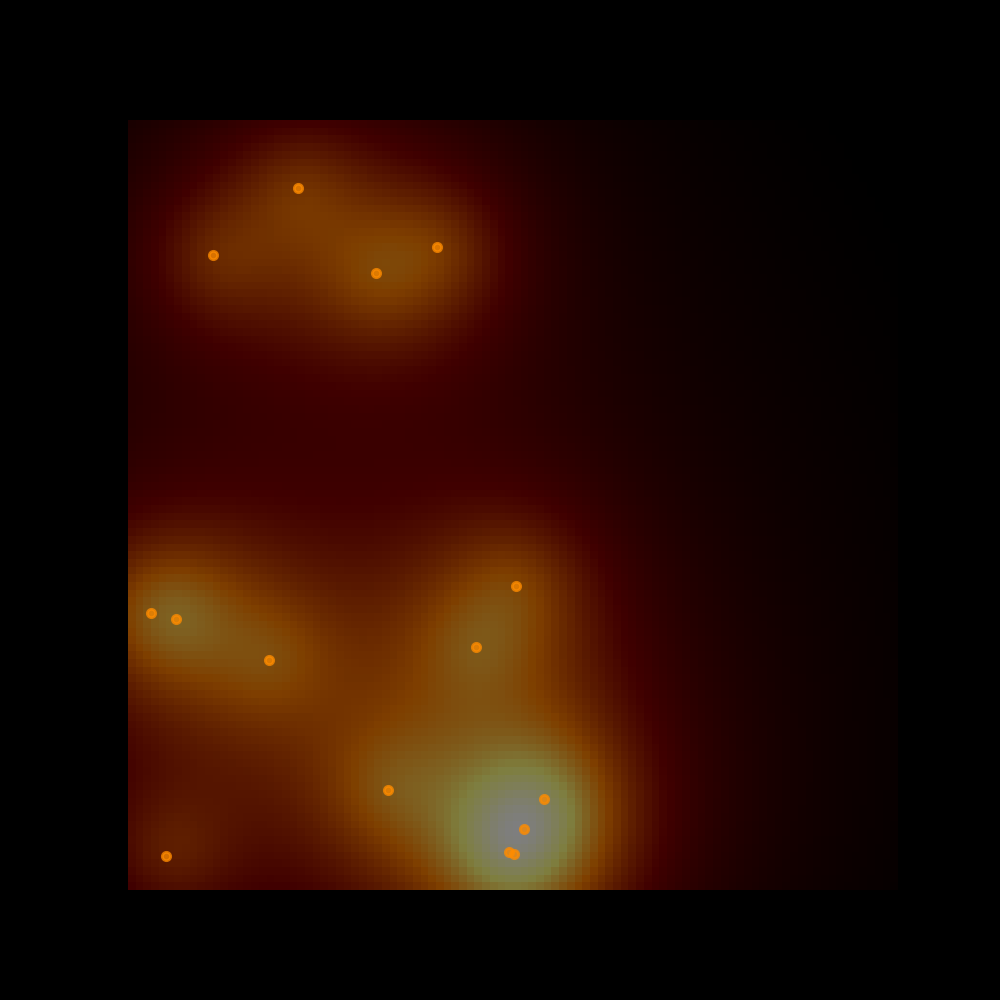

(0.0, 1.0, 0.0, 1.0)

In [239]:
fig, ax   = plt.subplots(1, 1, figsize=(5,5))

xmin, xmax, ymin, ymax = (0., 1., 0., 1.)

N         = 100
xx, yy    = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
epsilon   = 0.1

weights   = np.zeros_like(xx) 


for par in pos:
  weights += 1. / ((xx - par[0])**2 + (yy - par[1])**2 + epsilon**2.)

ax.imshow(weights, extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.afmhot, alpha=0.5, origin='lower')

ax.plot(pos[:,0], pos[:,1], '.', c='darkorange', alpha=0.75)
ax.tick_params(labelbottom=False, labelleft=False)  

ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)

plt.axis('off')

This work was the original concept of gravitational 'n-body' simulations that are described below.  It's almost criminal that only 118 publications have referenced this groundbreaking idea.

<img src="images/Holmberg.png" alt="Drawing" style="width: 800px;"/>

Today, given the mini supercomputers we often have at our fingertips, we can determine the final distribution of dark matter more accurately with computers than light bulbs.  By evolving an initial homogeneous distribution (a uniform distribution of dark matter clumps) under gravity.  To do this, we just need to calculate the acceleration on each particle at a series of time steps and update the velocity and position accordingly according to the acceleration that is felt.

In [240]:
# We'll sample the equations of motion in discrete time steps. 
dt         = 1.e-2
nsteps     = 500

timesteps  = np.linspace(0.0, nsteps * dt, nsteps)
dt         = np.diff(timesteps)[0]

mass       = 0.25

Now we simply have to run the simulation,

<IPython.core.display.Javascript object>


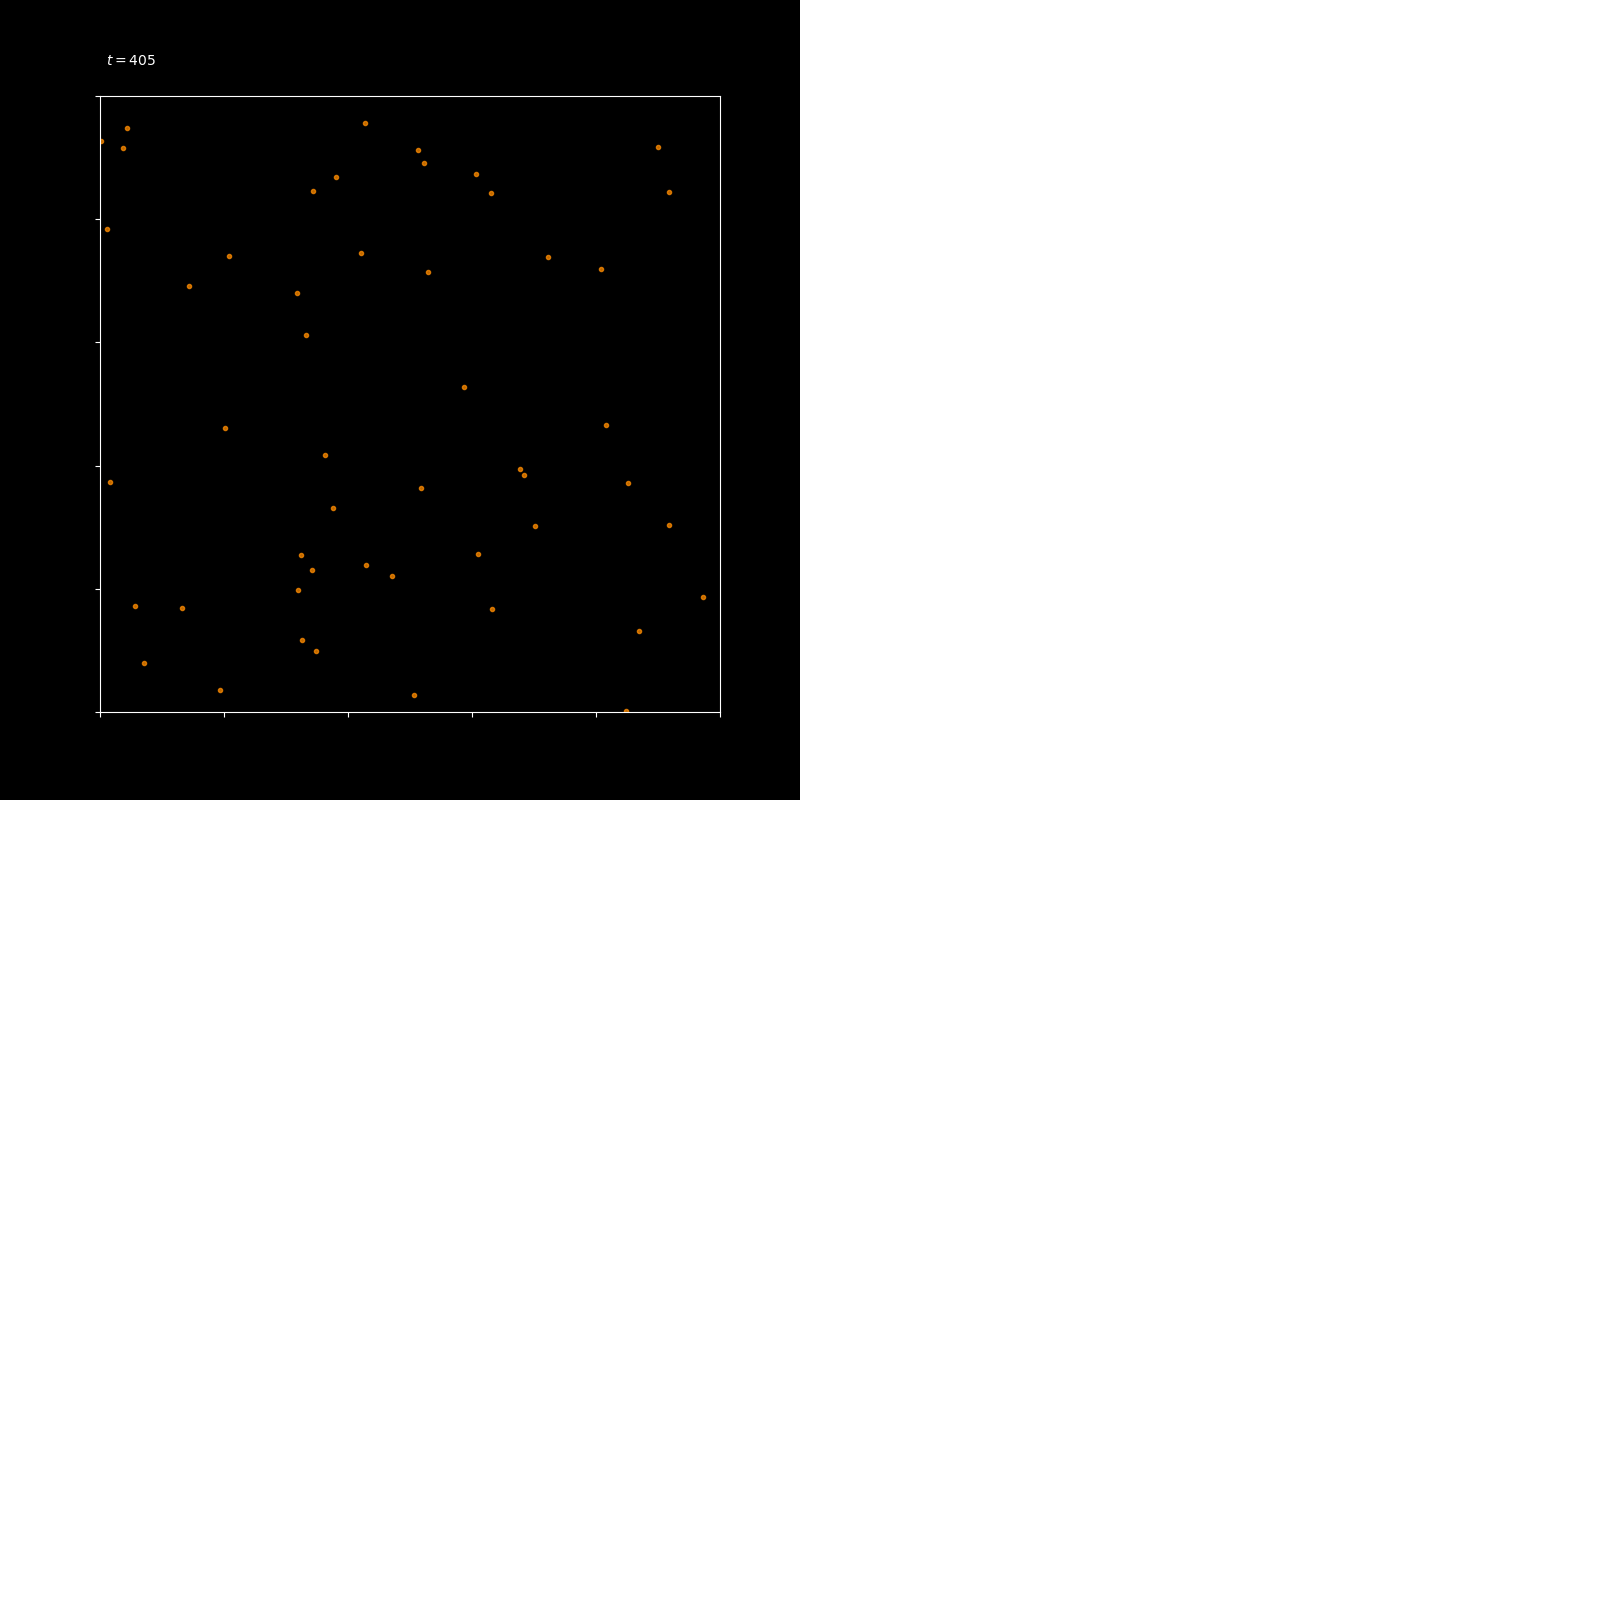

KeyboardInterrupt: 

In [241]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.tick_params(labelbottom=False, labelleft=False)  

plt.axis('off')

# Reinitialise particles.
pos, vel = init_dof(npt=50)

for index_in_timestep , time in enumerate(timesteps):    
    pl.cla()
    
    ax.text(0.01, 1.05, '$t={:d}$'.format(index_in_timestep), transform=ax.transAxes)

    dvel                        = np.zeros_like(vel)
    dpos                        = np.zeros_like(pos)
    
    for index_in_particle, _ in enumerate(pos):
        g_X                     = g_at_particle(index_in_particle, pos, mass, doimages=True)
        
        # Update velocities. 
        dvel[index_in_particle] = dt * g_X 
        
        # Update positions.
        dpos[index_in_particle] = dt * vel[index_in_particle]           
        
    vel += dvel
    pos += dpos
    
    # Our simulation has periodic boundaries, if you go off one side you come back on the other!
    pos = pos % 1.
    
    ax.plot(pos[:,0], pos[:,1], '.', c='darkorange', alpha=0.75)
    
    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)
    
    fig.canvas.draw()

Now, when DESI runs huge simulations, such as those run on Summit, a total of ~48 _trillion_ particles are solved for.  Don't try this here!  But the results are really quite extraordinary (skip to 6 mins 45 seconds if you're impatient to see the result!):

In [ ]:
YouTubeVideo('LQMLFryA_7k', width=800, height=400)